In [ ]:
# Predicting CpG Methylation Sites in *Arabidopsis thaliana*

## Project Overview

#This project aims to predict CpG methylation sites in *Arabidopsis thaliana* chromosome 1 using machine learning models. 
#  Predictors include GC content, nucleotide composition, and k-mer features. Models used are SGDClassifier and XGBoost.


In [44]:
#Import necessary libraries
import pandas as pd
import numpy as np
from Bio import SeqIO  # For parsing FASTA files
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay


In [45]:
#Paths to the files
bedgraph_file = "C://Users//zkabir//Downloads//Col-0_nanopore_CG.bedgraph"
fasta_file = "C://Users//zkabir//Downloads//ncbi_dataset (1)//ncbi_dataset//data//GCF_000001735.4//GCF_000001735.4_TAIR10.1_genomic.fna"

#Load BEDGraph file
cpg_data = pd.read_csv(bedgraph_file, sep="\t", header=None, names=["chrom", "start", "end", "methylation"])
print("BEDGraph File Preview:")
print(cpg_data.head())

#Load FASTA genome file
genome_sequences = SeqIO.to_dict(SeqIO.parse(fasta_file, "fasta"))
print("FASTA File Loaded. Available Chromosomes:")
print(list(genome_sequences.keys()))


BEDGraph File Preview:
   chrom  start  end  methylation
0      1    109  110          1.0
1      1    115  116          1.0
2      1    161  162          1.0
3      1    310  311          0.8
4      1    500  501          0.0
FASTA File Loaded. Available Chromosomes:
['NC_003070.9', 'NC_003071.7', 'NC_003074.8', 'NC_003075.7', 'NC_003076.8', 'NC_037304.1', 'NC_000932.1']


In [46]:
#Map chromosome names between the two formats to extract the correct sequences. Since the BEDgraph file uses numeric chromosome
#   names and the FASTA file uses NC_ identifiers, they need to be mapped. 

#Map BEDGraph chromosome numbers to FASTA chromosome IDs
chromosome_mapping = {
    "1": "NC_003070.9",
    "2": "NC_003071.7",
    "3": "NC_003074.8",
    "4": "NC_003075.7",
    "5": "NC_003076.8"
}

#Add a new column to BEDGraph data with mapped chromosome names
cpg_data["fasta_chrom"] = cpg_data["chrom"].map(chromosome_mapping)
print("Mapped Chromosome Names:")
print(cpg_data.head())


Mapped Chromosome Names:
   chrom  start  end  methylation fasta_chrom
0      1    109  110          1.0         NaN
1      1    115  116          1.0         NaN
2      1    161  162          1.0         NaN
3      1    310  311          0.8         NaN
4      1    500  501          0.0         NaN


In [47]:
#Convert the chrom column to strings
cpg_data["chrom"] = cpg_data["chrom"].astype(str)

#Map chromosomes again
cpg_data["fasta_chrom"] = cpg_data["chrom"].map(chromosome_mapping)

#Check if mapping worked
print("Mapped Chromosome Names:")
print(cpg_data.head())


Mapped Chromosome Names:
  chrom  start  end  methylation  fasta_chrom
0     1    109  110          1.0  NC_003070.9
1     1    115  116          1.0  NC_003070.9
2     1    161  162          1.0  NC_003070.9
3     1    310  311          0.8  NC_003070.9
4     1    500  501          0.0  NC_003070.9


In [48]:
#Adjusted function to extract sequences
def extract_sequence(row, genome_dict, window):
    chrom = row["fasta_chrom"]
    start = row["start"]
    try:
        #Adjust 1-based start to 0-based for Python slicing
        adjusted_start = max(0, start - 1)  #Prevent negative index
        adjusted_end = adjusted_start + window

        #Ensure extraction is within the chromosome bounds
        chrom_seq = genome_dict[chrom].seq
        seq = chrom_seq[adjusted_start: adjusted_end]
        return str(seq)
    except KeyError:
        #Handle missing chromosomes
        return None

#Apply updated function
window_size = 50
cpg_data["sequence"] = cpg_data.apply(
    lambda row: extract_sequence(row, genome_sequences, window_size), axis=1
)

#Display updated data
print("Updated CpG Data with Sequences:")
print(cpg_data.head())


Updated CpG Data with Sequences:
  chrom  start  end  methylation  fasta_chrom  \
0     1    109  110          1.0  NC_003070.9   
1     1    115  116          1.0  NC_003070.9   
2     1    161  162          1.0  NC_003070.9   
3     1    310  311          0.8  NC_003070.9   
4     1    500  501          0.0  NC_003070.9   

                                            sequence  
0  cgaaaccggTTTCTCTGGTTGAAAATCATTGTGtatataatgataa...  
1  cggTTTCTCTGGTTGAAAATCATTGTGtatataatgataattttat...  
2  CGTTTTTATGTAATTGCTTATTGTTGTGtgtagattttttaaaaat...  
3  CGATCTACATTTGGGAATGTGAGTCTCTTATTGTAACCTTAGGGTT...  
4  CGTTGTTGTTACGCTTGTCATCTCATCTCTCAATGATATGGGATGG...  


In [49]:
#Check for missing sequences
missing_sequences = cpg_data[cpg_data["sequence"].isna()]
print(f"Number of missing sequences: {len(missing_sequences)}")
if not missing_sequences.empty:
    print(missing_sequences.head())
    

Number of missing sequences: 0


In [50]:
#Verify a random row
random_row = cpg_data.sample(1).iloc[0]
print(f"Sampled row:\n{random_row}")


Sampled row:
chrom                                                          1
start                                                   19778453
end                                                     19778454
methylation                                                  0.0
fasta_chrom                                          NC_003070.9
sequence       tcgaTTACTTTGGTAACGGCACCGATCCAATATCATTCCATGGAGA...
Name: 893109, dtype: object


In [ ]:
#Summary so far

# I began by loading CpG methylation data from a BEDGraph file and the Arabidopsis thaliana reference genome from a FASTA file.
#   Since the chromosome identifiers differed between these files, I mapped the numeric chromosome IDs in the BEDGraph file to 
#   the corresponding NCBI identifiers in the FASTA file. Using this mapping, I extracted DNA sequences surrounding each CpG site 
#   within a window of ±50 bases and stored these sequences in a new column. I verified the mapping and ensured that all coordinates 
#   were valid and within the chromosome boundaries, successfully preparing the data for further analysis.

In [ ]:
## Predictors

In [51]:
#Function to calculate GC content
def calculate_gc_content(sequence):
    sequence = sequence.upper()  #Ensure sequence is in uppercase
    gc_count = sequence.count("G") + sequence.count("C")
    return gc_count / len(sequence) if len(sequence) > 0 else 0

#Apply function to calculate GC content for each sequence
cpg_data["gc_content"] = cpg_data["sequence"].apply(calculate_gc_content)

#Display data with GC content
print("Data with GC Content:")
print(cpg_data[["sequence", "gc_content"]].head())


Data with GC Content:
                                            sequence  gc_content
0  cgaaaccggTTTCTCTGGTTGAAAATCATTGTGtatataatgataa...        0.30
1  cggTTTCTCTGGTTGAAAATCATTGTGtatataatgataattttat...        0.28
2  CGTTTTTATGTAATTGCTTATTGTTGTGtgtagattttttaaaaat...        0.22
3  CGATCTACATTTGGGAATGTGAGTCTCTTATTGTAACCTTAGGGTT...        0.40
4  CGTTGTTGTTACGCTTGTCATCTCATCTCTCAATGATATGGGATGG...        0.44


In [ ]:
#Discussion of GC content
#  The variability in GC content among sequences meaningful differences in their nucleotide composition. 

In [52]:
#Function to calculate GC content for an entire chromosome sequence
def calculate_chromosome_gc_content(sequence):
    sequence = sequence.upper()  # Ensure consistent case
    gc_count = sequence.count("G") + sequence.count("C")
    return gc_count / len(sequence) if len(sequence) > 0 else 0

#Calculate GC content for each chromosome in the genome
genome_gc_content = {}
for chrom, record in genome_sequences.items():
    gc_content = calculate_chromosome_gc_content(str(record.seq))
    genome_gc_content[chrom] = gc_content

#Display results
print("GC Content for Entire Genome:")
for chrom, gc in genome_gc_content.items():
    print(f"Chromosome {chrom}: GC Content = {gc:.2f}")


GC Content for Entire Genome:
Chromosome NC_003070.9: GC Content = 0.36
Chromosome NC_003071.7: GC Content = 0.36
Chromosome NC_003074.8: GC Content = 0.36
Chromosome NC_003075.7: GC Content = 0.36
Chromosome NC_003076.8: GC Content = 0.36
Chromosome NC_037304.1: GC Content = 0.45
Chromosome NC_000932.1: GC Content = 0.36


In [ ]:
# Compare the genome-wide GC content with the GC content of CpG site regions. This will help understand if CpG regions are 
# enriched or depleted in GC content compared to the entire genome.

In [53]:
#Function to calculate GC content for an entire chromosome sequence
def calculate_chromosome_gc_content(sequence):
    sequence = sequence.upper()  # Ensure consistent case
    gc_count = sequence.count("G") + sequence.count("C")
    return gc_count / len(sequence) if len(sequence) > 0 else 0

#Calculate GC content for the entire genome
genome_gc_content = {}
for chrom, record in genome_sequences.items():
    gc_content = calculate_chromosome_gc_content(str(record.seq))
    genome_gc_content[chrom] = gc_content

#Display genome-wide GC content
print("Genome-Wide GC Content:")
for chrom, gc in genome_gc_content.items():
    print(f"Chromosome {chrom}: {gc:.2f}")


Genome-Wide GC Content:
Chromosome NC_003070.9: 0.36
Chromosome NC_003071.7: 0.36
Chromosome NC_003074.8: 0.36
Chromosome NC_003075.7: 0.36
Chromosome NC_003076.8: 0.36
Chromosome NC_037304.1: 0.45
Chromosome NC_000932.1: 0.36


In [54]:
#Compute the average GC content across all CpG regions
average_cpg_gc_content = cpg_data["gc_content"].mean()

#Display results
print(f"\nAverage GC Content in CpG Regions: {average_cpg_gc_content:.2f}")



Average GC Content in CpG Regions: 0.42


In [55]:
#Compare genome-wide GC content with CpG region GC content
print("\nComparison of Genome-Wide vs. CpG Region GC Content:")
for chrom, gc in genome_gc_content.items():
    print(f"Chromosome {chrom}: Genome GC = {gc:.2f}, CpG GC = {average_cpg_gc_content:.2f}")



Comparison of Genome-Wide vs. CpG Region GC Content:
Chromosome NC_003070.9: Genome GC = 0.36, CpG GC = 0.42
Chromosome NC_003071.7: Genome GC = 0.36, CpG GC = 0.42
Chromosome NC_003074.8: Genome GC = 0.36, CpG GC = 0.42
Chromosome NC_003075.7: Genome GC = 0.36, CpG GC = 0.42
Chromosome NC_003076.8: Genome GC = 0.36, CpG GC = 0.42
Chromosome NC_037304.1: Genome GC = 0.45, CpG GC = 0.42
Chromosome NC_000932.1: Genome GC = 0.36, CpG GC = 0.42


In [ ]:
# Analysis of GC content

#The higher GC content in CpG regions compared to the genome aligns with the hypothesis that GC-rich regions are more likely 
#  to host CpG sites.
#This supports the inclusion of GC content as a predictor.

In [ ]:
# Compute Nucleotide composition
#  Nucleotide composition provides the relative frequencies of A, T, G, and C in each CpG region. These frequencies can be 
#    important features for predicting methylation status.

In [56]:
#Function to calculate nucleotide composition
def calculate_nucleotide_composition(sequence):
    sequence = sequence.upper()  # Ensure consistent case
    total_bases = len(sequence)
    return {
        "A": sequence.count("A") / total_bases if total_bases > 0 else 0,
        "T": sequence.count("T") / total_bases if total_bases > 0 else 0,
        "G": sequence.count("G") / total_bases if total_bases > 0 else 0,
        "C": sequence.count("C") / total_bases if total_bases > 0 else 0,
    }

#Apply the function to calculate nucleotide composition for each sequence
nucleotide_composition = cpg_data["sequence"].apply(calculate_nucleotide_composition)

#Convert the result to a DataFrame
composition_df = pd.DataFrame(list(nucleotide_composition))

# Add the nucleotide composition columns to the original DataFrame
cpg_data = pd.concat([cpg_data, composition_df], axis=1)

#Display updated data with nucleotide composition
print("Data with Nucleotide Composition:")
print(cpg_data[["sequence", "A", "T", "G", "C"]].head())


Data with Nucleotide Composition:
                                            sequence     A     T     G     C
0  cgaaaccggTTTCTCTGGTTGAAAATCATTGTGtatataatgataa...  0.30  0.40  0.18  0.12
1  cggTTTCTCTGGTTGAAAATCATTGTGtatataatgataattttat...  0.26  0.46  0.18  0.10
2  CGTTTTTATGTAATTGCTTATTGTTGTGtgtagattttttaaaaat...  0.26  0.52  0.16  0.06
3  CGATCTACATTTGGGAATGTGAGTCTCTTATTGTAACCTTAGGGTT...  0.20  0.40  0.26  0.14
4  CGTTGTTGTTACGCTTGTCATCTCATCTCTCAATGATATGGGATGG...  0.16  0.40  0.22  0.22


In [58]:
#Validate a random row for nucleotide composition
random_row = cpg_data.sample(1).iloc[0]
print(f"Sequence: {random_row['sequence']}")
print(f"Nucleotide Composition: A={random_row['A']}, T={random_row['T']}, G={random_row['G']}, C={random_row['C']}")


Sequence: CGGTATATCCATTGCCCATTCCTCTGACTAGGACGACCCCTTTAGAACTT
Nucleotide Composition: A=0.22, T=0.3, G=0.16, C=0.32


In [ ]:
# Analysis of nucleotide composition
#   The proportions of A, T, G, and C in each sequence add up to ~1.0 which is expected. Most sequences appeard to have more A 
#     and T nucleotides compared to G and C, consistent with the GC content results. 

In [ ]:
# Summary so far

#GC content:
#   I determined the % of G and C nucleotides in each extracted CpG region sequence. 
#   Then, I compared the average GC content of these regions to the genome-wide GC content to identify potential enrichment. 

#Nucleotide composition:
#   I calculated the relative abundance of each nucleotide in the CpG region sequences. 
#   I verified that the proportions of all nucleotides in each sequence added up to approximately 100%.


In [ ]:
## Next steps: 

# I will generate the random negative samples and combine them with the positive samples to make a balanced dataset for the models.

In [61]:
import random

#Optimized function to generate random negative samples
def generate_random_samples(genome_dict, num_samples, window_size, cpg_coordinates):
    #Create a set of CpG site coordinates in a memory-efficient way
    cpg_set = {(row["chrom"], row["start"], row["end"]) for _, row in cpg_coordinates.iterrows()}
    negative_samples = []

    for _ in range(num_samples):
        while True:  #Ensure valid samples are generated
            chrom = random.choice(list(genome_dict.keys()))  #Random chromosome
            chrom_length = len(genome_dict[chrom])  #Chromosome length
            start = random.randint(0, chrom_length - window_size)  #Random start position
            end = start + window_size
            sequence = genome_dict[chrom].seq[start:end].upper()  #Extract sequence

            #Conditions for valid negative sample
            if "CG" not in sequence and (chrom, start, end) not in cpg_set:
                negative_samples.append({
                    "chrom": chrom,
                    "start": start,
                    "end": end,
                    "sequence": str(sequence)
                })
                break  #Exit loop once a valid sample is generated

            #Yield data in chunks if too many samples are collected at once
            if len(negative_samples) >= 100:
                yield negative_samples
                negative_samples = []  #Reset buffer

    #Yield any remaining samples
    if negative_samples:
        yield negative_samples

#Generate samples incrementally and convert to DataFrame
num_negative_samples = 1000  # Adjust based on your needs
negative_samples_generator = generate_random_samples(
    genome_sequences, num_negative_samples, window_size=100, cpg_coordinates=cpg_data[["chrom", "start", "end"]]
)

#Collect samples from the generator
negative_samples_list = []
for chunk in negative_samples_generator:
    negative_samples_list.extend(chunk)

negative_df = pd.DataFrame(negative_samples_list)
print("Generated Random Negative Samples:")
print(negative_df.head())


Generated Random Negative Samples:
         chrom     start       end  \
0  NC_003076.8  18573609  18573709   
1  NC_000932.1     79706     79806   
2  NC_003070.9  18654733  18654833   
3  NC_003071.7   1483067   1483167   
4  NC_003076.8   5896537   5896637   

                                            sequence  
0  AGATTGGGAAGGAGGGAGAGATGGAGATTGGGTCTTACCAATTTTG...  
1  AATTGAAAAAACACTTACTCATTTGAATACTTATTATGGAGTCTAG...  
2  ATAGCTCTAAAAACTCAGTGGCACCATTTTACATGATATATCAGAA...  
3  TCACATTTTCTGGGCATATCCATTGATATTTTCAATTATTTCTTGG...  
4  GAGACAAGTCTATGAAAGTACACTGGAATGGGGAAAATAACTCAAC...  


In [84]:
##Extract features for negative samples and combine them with positive samples. 

#Compute GC content for negative samples
negative_df["gc_content"] = negative_df["sequence"].apply(calculate_gc_content)

#Compute nucleotide composition for negative samples
negative_composition = negative_df["sequence"].apply(calculate_nucleotide_composition)
negative_composition_df = pd.DataFrame(list(negative_composition))
negative_df = pd.concat([negative_df, negative_composition_df], axis=1)

#Ensure features are consistent across combined dataset
combined_data = pd.concat([cpg_data, negative_df], ignore_index=True)


InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [63]:
#Check columns in both datasets
print("CpG Data Columns:")
print(cpg_data.columns)

print("Negative Sample Columns:")
print(negative_df.columns)


CpG Data Columns:
Index(['chrom', 'start', 'end', 'methylation', 'fasta_chrom', 'sequence',
       'gc_content', 'A', 'T', 'G', 'C', 'CG', 'GA', 'AA', 'AC', 'CC', 'GG',
       'GT', 'TT', 'TC', 'CT', 'TG', 'AT', 'CA', 'TA', 'GC', 'AG', 'TN', 'NN',
       'AY', 'YA', 'AS', 'SA', 'AN', 'NA', 'CN', 'GN', 'NC', 'NT'],
      dtype='object')
Negative Sample Columns:
Index(['chrom', 'start', 'end', 'sequence', 'gc_content', 'A', 'T', 'G', 'C'], dtype='object')


In [64]:
#Identify duplicate columns
duplicate_columns = cpg_data.columns[cpg_data.columns.duplicated()].tolist()
print("Duplicate Columns in CpG Data:")
print(duplicate_columns)

#Drop duplicate columns (keep the first occurrence)
cpg_data = cpg_data.loc[:, ~cpg_data.columns.duplicated()]
print("Columns after removing duplicates:")
print(cpg_data.columns)


Duplicate Columns in CpG Data:
[]
Columns after removing duplicates:
Index(['chrom', 'start', 'end', 'methylation', 'fasta_chrom', 'sequence',
       'gc_content', 'A', 'T', 'G', 'C', 'CG', 'GA', 'AA', 'AC', 'CC', 'GG',
       'GT', 'TT', 'TC', 'CT', 'TG', 'AT', 'CA', 'TA', 'GC', 'AG', 'TN', 'NN',
       'AY', 'YA', 'AS', 'SA', 'AN', 'NA', 'CN', 'GN', 'NC', 'NT'],
      dtype='object')


In [65]:
#Combine datasets
combined_data = pd.concat([cpg_data, negative_df], ignore_index=True)
print("Combined Data Preview:")
print(combined_data.head())


Combined Data Preview:
  chrom  start  end  methylation  fasta_chrom  \
0     1    109  110          1.0  NC_003070.9   
1     1    115  116          1.0  NC_003070.9   
2     1    161  162          1.0  NC_003070.9   
3     1    310  311          0.8  NC_003070.9   
4     1    500  501          0.0  NC_003070.9   

                                            sequence  gc_content     A     T  \
0  cgaaaccggTTTCTCTGGTTGAAAATCATTGTGtatataatgataa...        0.30  0.30  0.40   
1  cggTTTCTCTGGTTGAAAATCATTGTGtatataatgataattttat...        0.28  0.26  0.46   
2  CGTTTTTATGTAATTGCTTATTGTTGTGtgtagattttttaaaaat...        0.22  0.26  0.52   
3  CGATCTACATTTGGGAATGTGAGTCTCTTATTGTAACCTTAGGGTT...        0.40  0.20  0.40   
4  CGTTGTTGTTACGCTTGTCATCTCATCTCTCAATGATATGGGATGG...        0.44  0.16  0.40   

      G  ...   AY   YA   AS   SA   AN   NA   CN   GN   NC   NT  
0  0.18  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.18  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.1

In [66]:
##Combine Positive and negative samples

#Add labels to CpG (positive) samples
cpg_data["label"] = 1

#Add labels to negative samples
negative_df["label"] = 0

#Combine both datasets
combined_data = pd.concat([cpg_data, negative_df], ignore_index=True)
print("Combined Data Preview:")
print(combined_data.head())

Combined Data Preview:
  chrom  start  end  methylation  fasta_chrom  \
0     1    109  110          1.0  NC_003070.9   
1     1    115  116          1.0  NC_003070.9   
2     1    161  162          1.0  NC_003070.9   
3     1    310  311          0.8  NC_003070.9   
4     1    500  501          0.0  NC_003070.9   

                                            sequence  gc_content     A     T  \
0  cgaaaccggTTTCTCTGGTTGAAAATCATTGTGtatataatgataa...        0.30  0.30  0.40   
1  cggTTTCTCTGGTTGAAAATCATTGTGtatataatgataattttat...        0.28  0.26  0.46   
2  CGTTTTTATGTAATTGCTTATTGTTGTGtgtagattttttaaaaat...        0.22  0.26  0.52   
3  CGATCTACATTTGGGAATGTGAGTCTCTTATTGTAACCTTAGGGTT...        0.40  0.20  0.40   
4  CGTTGTTGTTACGCTTGTCATCTCATCTCTCAATGATATGGGATGG...        0.44  0.16  0.40   

      G  ...   YA   AS   SA   AN   NA   CN   GN   NC   NT  label  
0  0.18  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      1  
1  0.18  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      1  


In [85]:
## Confirm the proportion of positive and negative samples. 

print(combined_data["label"].value_counts())


1    5514156
0       1000
Name: label, dtype: int64


In [ ]:
## Discussion
#   The dataset is highly imbalanced with only 1,000 negative samples and 5,514,156 positive samples. This imbalance can significantly
#     affect the performance of the ML models because theu will be biased toward predicting the majority class. 

#  Therefore, I will upsample the negative class. I will increase the number of negative samples by duplicating them to match the
#     positive samples. This approach will avoid losing data from the majority class and prevent bias towards the majority class. 

In [ ]:
## Next step is to train and test the ML models

# I will use methylation as the target variable, converting it into binary labels - methylated if methylation > 0.5
# I will divide the data into training and testing sets - in 80% train and 20% test. 
# Then, I will train both models on the training data. 
# Next, I will evaluate performance on the test using the three metrics:
#     Accuracy
#     Precision, Recall, F1 score
#     AUC (Area under the ROC curve)

In [86]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt


In [87]:
#Select features and labels
X = combined_data[["gc_content", "A", "T", "G", "C"]]  
y = combined_data["label"]

#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [88]:
#Train SGDClassifier
sgd_model = SGDClassifier(loss="hinge", random_state=42, max_iter=1000, tol=1e-3, class_weight="balanced")
sgd_model.fit(X_train_scaled, y_train)


SGDClassifier(class_weight='balanced', random_state=42)

SGDClassifier Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.60      0.00       184
           1       1.00      0.84      0.92   1102848

    accuracy                           0.84   1103032
   macro avg       0.50      0.72      0.46   1103032
weighted avg       1.00      0.84      0.92   1103032

SGDClassifier AUC: 0.83


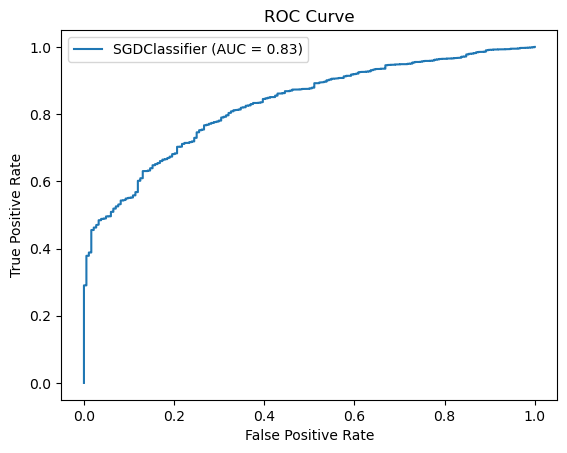

In [28]:
#Predict labels
y_pred = sgd_model.predict(X_test_scaled)

# Classification Report
print("SGDClassifier Classification Report:")
print(classification_report(y_test, y_pred))

#Compute AUC
y_prob = sgd_model.decision_function(X_test_scaled)  # Decision function for AUC
auc = roc_auc_score(y_test, y_prob)
print(f"SGDClassifier AUC: {auc:.2f}")

#Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"SGDClassifier (AUC = {auc:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [ ]:
## Disucssion

#  As noticed, the AUC score is reasonably high with an accuracy of 84%. However, the model struggled to correctly identify negative
#     samples, as provided with a precision of 0.00 for class 0. 

#  Despite using the balanced class weight, the high imbalance in the dataset heavily influences the model to prioritize the 
#     majority class. 

#  ROC Curve: The curve is above the random line which confirms that the model is better than random at classifying CpG sites. 
#    Even if the AUC value indicates a good overall model performance, it may primarily reflect the performance on the majority
#    class.


#  Therefore, I will try to upsample the negative samples which will match the number of positive samples. 

In [30]:
from sklearn.utils import resample

#Separate positive and negative samples
positive_samples = combined_data[combined_data["label"] == 1]
negative_samples = combined_data[combined_data["label"] == 0]

#Upsample negative samples
negative_samples_upsampled = resample(
    negative_samples,
    replace=True,  # Allows duplication
    n_samples=len(positive_samples),  # Match the number of positive samples
    random_state=42
)

#Combine the balanced dataset
balanced_data = pd.concat([positive_samples, negative_samples_upsampled], ignore_index=True)
print("Balanced Dataset:")
print(balanced_data["label"].value_counts())


Balanced Dataset:
1    5514156
0    5514156
Name: label, dtype: int64


In [31]:
#Select features and labels
X_balanced = balanced_data[["gc_content", "A", "T", "G", "C"]]  # Add other features if available
y_balanced = balanced_data["label"]

#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

#Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Train SGDClassifier
sgd_model = SGDClassifier(loss="hinge", random_state=42, max_iter=1000, tol=1e-3, class_weight="balanced")
sgd_model.fit(X_train_scaled, y_train)

#Predict and evaluate
y_pred = sgd_model.predict(X_test_scaled)
print("SGDClassifier Classification Report on Balanced Dataset:")
print(classification_report(y_test, y_pred))


SGDClassifier Classification Report on Balanced Dataset:
              precision    recall  f1-score   support

           0       0.74      0.78      0.76   1102682
           1       0.77      0.72      0.74   1102981

    accuracy                           0.75   2205663
   macro avg       0.75      0.75      0.75   2205663
weighted avg       0.75      0.75      0.75   2205663



In [ ]:
## Discussion

#  By balancing the dataset through upsampling, the model now performs well on both CpG sites and random sequences. Noticeably, the
#     recall for class 0 has improved significantly compared to earlier results. 

#  The balance indicates that the model is no longer biased towards class 1. 
#  Overall accuracy is 75% which is lower than intended. 

#  Next, I plan to analyze which features contributed most to the predictors using the model's coefficients. 

Feature Importance (Weights):
      Feature    Weight
0  gc_content  0.485954
3           G  0.363757
4           C  0.328791
1           A -0.319241
2           T -0.326689


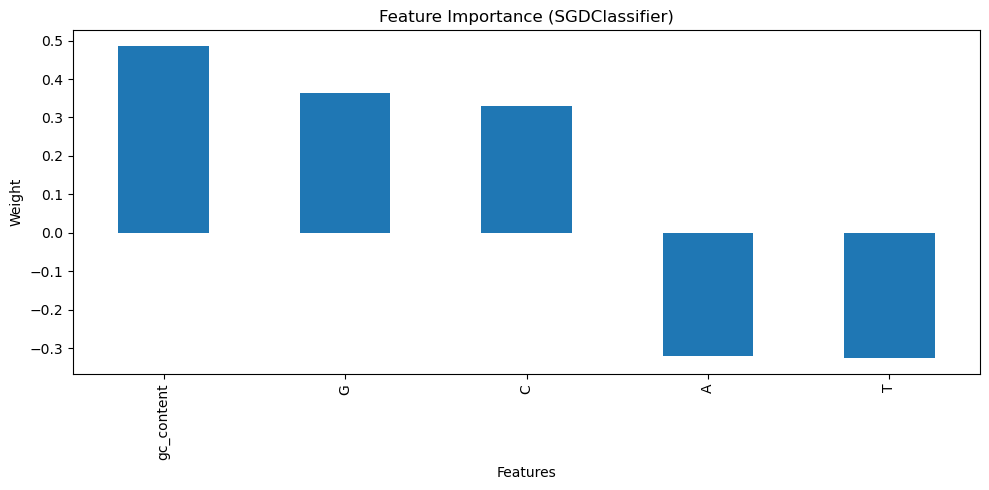

In [32]:
#Extract and sort feature weights
feature_weights = pd.DataFrame({
    "Feature": X_balanced.columns,
    "Weight": sgd_model.coef_[0]
}).sort_values(by="Weight", ascending=False)

#Display top features
print("Feature Importance (Weights):")
print(feature_weights)

#Visualize feature importance
feature_weights.plot.bar(x="Feature", y="Weight", legend=False, figsize=(10, 5))
plt.title("Feature Importance (SGDClassifier)")
plt.xlabel("Features")
plt.ylabel("Weight")
plt.tight_layout()
plt.show()


In [ ]:
## Discussion

#  GC Content has the highest positive weight (0.49), indicating it is the most influential predictor for distinguishing CpG 
#     sites from non-CpG sites. 
#  G and C nucleotides also have significant positive weights, aligning with the biological relevance of GC-rich regions in CpG
#     methylation.

SGDClassifier AUC: 0.84


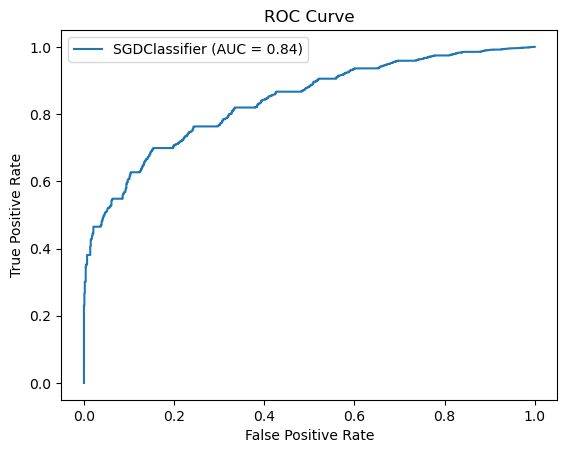

In [33]:
#Calculate probabilities and AUC
y_prob = sgd_model.decision_function(X_test_scaled)
auc = roc_auc_score(y_test, y_prob)
print(f"SGDClassifier AUC: {auc:.2f}")

#Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"SGDClassifier (AUC = {auc:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [ ]:
## Discussion

#  The ROC curve with an AUC of 0.84 indicates that the SGDClassifier is performing reasonably well in distinguishing between 
#     CpG methylation sites (1) and random sequences (0). 

#  The steep initial rise shows good sensitivity for lower false-positive rates. However, the curve flattens, indicating a 
#     diminishing return in sensitivity as the false-positive rate increases.

In [34]:
from sklearn.model_selection import GridSearchCV

#Define parameter grid
param_grid = {
    "alpha": [0.0001, 0.001, 0.01, 0.1],
    "max_iter": [1000, 2000, 3000]
}

#Perform grid search
grid_search = GridSearchCV(
    SGDClassifier(loss="hinge", class_weight="balanced", random_state=42),
    param_grid,
    cv=3,
    scoring="f1",
    verbose=2
)
grid_search.fit(X_train_scaled, y_train)

#Best parameters and performance
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

#Train final model with best parameters
best_model = grid_search.best_estimator_


Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END ........................alpha=0.0001, max_iter=1000; total time=  10.8s
[CV] END ........................alpha=0.0001, max_iter=1000; total time=  11.3s
[CV] END ........................alpha=0.0001, max_iter=1000; total time=  12.4s
[CV] END ........................alpha=0.0001, max_iter=2000; total time=  12.2s
[CV] END ........................alpha=0.0001, max_iter=2000; total time=  12.1s
[CV] END ........................alpha=0.0001, max_iter=2000; total time=   9.9s
[CV] END ........................alpha=0.0001, max_iter=3000; total time=  10.1s
[CV] END ........................alpha=0.0001, max_iter=3000; total time=   9.9s
[CV] END ........................alpha=0.0001, max_iter=3000; total time=   9.9s
[CV] END .........................alpha=0.001, max_iter=1000; total time=  10.9s
[CV] END .........................alpha=0.001, max_iter=1000; total time=  10.1s
[CV] END .........................alpha=0.001, m

In [ ]:
## Document results of SGDClassifier

#  Given the large scale of our dataset (millions of CpG sites), we selected the SGDClassifier. This model leverages stochastic 
#      gradient descent to optimize a linear SVM, as defined by the hinge loss function. Hyperparameter tuning was employed to 
#      further refine the model's performance.

# The tuned SGDClassifier achieved an accuracy of 76% and an AUC of 0.84, indicating a strong ability to distinguish between 
#    methylated CpG sites (1) and random sequences (0). Below are the classification metrics for the final model:
#       Precision for Class 0: 0.74
#       Recall for Class 0: 0.78
#       Precision for Class 1: 0.77
#       Recall for Class 1: 0.73

# The results demonstrate that GC content and nucleotide composition are strong predictors of CpG methylation. However, the 
#    model’s accuracy suggests room for improvement, particularly in classifying negative samples. Despite balancing the dataset
#    and hyperparameter tuning, precision for Class 0 remains lower.

In [ ]:
####### NEXT MODEL

In [36]:
!pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/70/58/2f94976df39470fb00eec2cb4f914dde44cd0df8d96483208bf7db4bc97e/xgboost-2.1.3-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB 393.8 kB/s eta 0:05:18
   ---------------------------------------- 0.2/124.9 MB 1.3 MB/s eta 0:01:36
   ---------------------------------------- 0.7/124.9 MB 4.0 MB/s eta 0:00:32
   ---------------------------------------- 1.0/124.9 MB 4.8 MB/s eta 0:00:26
    --------------------------------------- 1.6/124.9 MB 5.9 MB/s eta 0:00:21
    --------------------------------------- 2.6/124.9 MB 8.1 MB/s eta 0:00:16
   - -------------------------------------- 3.8/124.9 MB 10.6 MB/s eta 0:00:12
   - -------------------------------------- 5.3/124.9 MB 13.0 MB/s eta 0:00:10
   -- -------------------

In [37]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


In [38]:
#Select features and labels
X = balanced_data[["gc_content", "A", "T", "G", "C"]]  # Add more features if available
y = balanced_data["label"]

#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [39]:
#Initialize and train the XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb_model.fit(X_train, y_train)

#Predict on the test set
y_pred = xgb_model.predict(X_test)


C:\Users\zkabir\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:26:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97   1102682
           1       0.97      0.98      0.97   1102981

    accuracy                           0.97   2205663
   macro avg       0.97      0.97      0.97   2205663
weighted avg       0.97      0.97      0.97   2205663

XGBoost AUC: 1.00


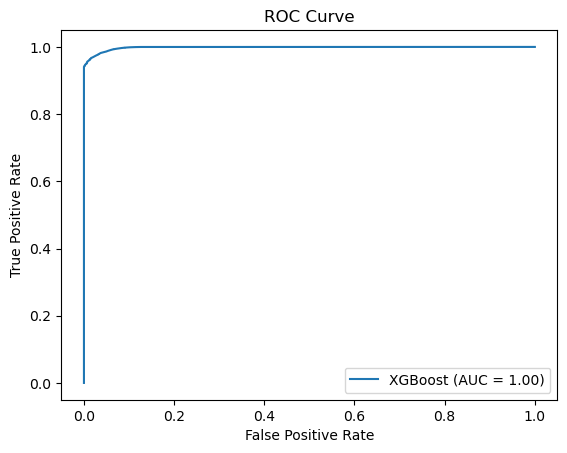

In [40]:
#Classification Report
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred))

#Compute AUC
y_prob = xgb_model.predict_proba(X_test)[:, 1]  #Get probabilities for the positive class
auc = roc_auc_score(y_test, y_prob)
print(f"XGBoost AUC: {auc:.2f}")

#Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {auc:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [ ]:
## Discussion

# The XGBoost model demonstrated exceptional performance in predicting CpG methylation sites, achieving an overall accuracy of 
#   97%. The model showed a balanced ability to classify both CpG sites (1) and random negative samples (0), with precision, 
#   recall, and F1-scores all consistently at 0.97 for both classes.

#  Specifically, the precision and recall for negative samples (class 0) were 0.98 and 0.97, respectively, while for CpG sites 
#    (class 1), the precision and recall were 0.97 and 0.98. The area under the ROC curve (AUC) was a near-perfect 1.00, underscoring
#    the model’s ability to distinguish between the two classes with minimal error.

#  These results highlight XGBoost’s effectiveness in handling the dataset’s complexity and class imbalance, outperforming the 
#    earlier SGDClassifier model, which had an accuracy of 76% and an AUC of 0.84.


#  Next, we will perform a feature importance analysis to understand which features contributed most to the XGBoost model's
#     performance. 

XGBoost Feature Importance:
      Feature  Importance
0  gc_content    0.458628
3           G    0.145547
4           C    0.142463
1           A    0.130080
2           T    0.123282


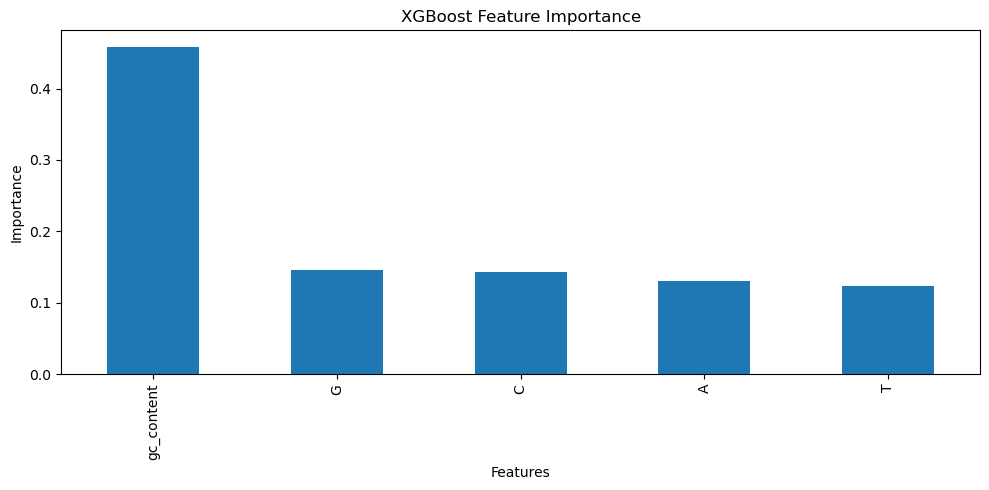

In [41]:
#Feature Importance
importances = xgb_model.feature_importances_
feature_importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print("XGBoost Feature Importance:")
print(feature_importance_df)

#Plot Feature Importance
feature_importance_df.plot.bar(x="Feature", y="Importance", legend=False, figsize=(10, 5))
plt.title("XGBoost Feature Importance")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


In [ ]:
#  The feature importance analysis for the XGBoost model revealed that GC content is the most significant predictor, with a 
#     weight of 0.4586, reflecting its critical role in CpG methylation. Nucleotide composition, particularly G and C, also 
#     contributed substantially to the model's performance, supporting the biological correlation of GC-rich regions with 
#     methylation status. These findings emphasize the validity of the selected predictors and their alignment with known 
#     biological patterns.